# Basic CNN Framework for Landsat Classification

In [1]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math

### importing datasets

In [2]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

landsat_dataset = rasterio.open('/deep_data/LC08_CU_028012_20140814_20171017_C01_V01_SR/combined.tif')


In [3]:
# What is the raster's projection?
image_proj = landsat_dataset.crs # 4326
print('Image projection:')
print(image_proj)

# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Labels projection:
EPSG:32618


## Data Generator and Prep Fcns

In [61]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                middle_pixel_r = r + np.ceil(tile_width/2)
                middle_pixel_c = c + np.ceil(tile_height/2)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(middle_pixel_r, middle_pixel_c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile
                    b += 1
        yield (image_batch, label_batch)
              

In [62]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a randomly selected number of pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    total_count = train_count + val_count
    for index, image_dataset in enumerate(image_datasets):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count)
        
        dataset_index = [index] * total_count
        
        dataset_pixels = list(zip(points, dataset_index))
        
        train_pixels += dataset_pixels[:train_count]
        val_pixels += dataset_pixels[train_count:]
        
        
    return (train_pixels, val_pixels)

In [60]:
11/2

5.5

## Test out the generator and data prep functions

In [51]:
# generate the training and validation pixel locations
train_px, val_px = gen_pixel_locations([landsat_dataset], 100, 20, 11)

In [52]:
# print out some image and label batches
im_batch = None

count = 0
for (im, label) in tile_generator([landsat_dataset], label_dataset, 11, 11, train_px, 2):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 11, 11, 7)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----


#### Visually inspect an image patch

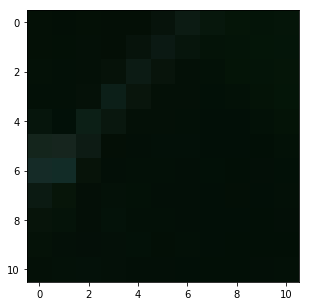

In [53]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,1:4])

## Let's get to the CNN

In [54]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

#### prep some of the hyperparameters

In [63]:
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 50

# input image dimensions
img_rows, img_cols = 11, 11
img_bands = landsat_dataset.count

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(11, 11, 7)


#### build the model

In [64]:
model = Sequential()
model.add(Conv2D(11, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(44, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 9, 9, 11)          704       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 22)          2200      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 22)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 3, 3, 22)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 198)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 44)                8756      
_________________________________________________________________
dropout_8 (Dropout)          (None, 44)                0         
__________

generate the pixel locations

In [65]:
train_px, val_px = gen_pixel_locations(image_datasets=[landsat_dataset], 
                                       train_count=10000, val_count=100, tile_size=11)

set up the remaining model hyperparameters and compile

In [66]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

train the model!

In [67]:
model.fit_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator([landsat_dataset], label_dataset, 11, 11, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50
400/400 [==============================] - 20s 49ms/step - loss: 2.0919 - acc: 0.3349 - val_loss: 1.9130 - val_acc: 0.1800
Epoch 2/50
400/400 [==============================] - 12s 31ms/step - loss: 1.9168 - acc: 0.3828 - val_loss: 1.9622 - val_acc: 0.1900
Epoch 3/50
400/400 [==============================] - 12s 31ms/step - loss: 1.8929 - acc: 0.3926 - val_loss: 1.9393 - val_acc: 0.2200
Epoch 4/50
400/400 [==============================] - 12s 30ms/step - loss: 1.8664 - acc: 0.3931 - val_loss: 1.9184 - val_acc: 0.3100
Epoch 5/50
400/400 [==============================] - 12s 31ms/step - loss: 1.8702 - acc: 0.3943 - val_loss: 1.9525 - val_acc: 0.3000
Epoch 6/50
400/400 [==============================] - 12s 31ms/step - loss: 1.8479 - acc: 0.3948 - val_loss: 1.8680 - val_acc: 0.2900
Epoch 7/50
400/400 [==============================] - 12s 31ms/step - loss: 1.8419 - acc: 0.4018 - val_loss: 1.8412 - val_acc: 0.3400
Epoch 8/50
400/400 [==============================] - 12s 31ms

In [69]:
test_px, val_px = gen_pixel_locations([landsat_dataset], 100, 20, 11)

In [75]:
model.evaluate_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

4/4 [==============================] - 7s 2s/step


[1.7472546696662903, 0.42000000178813934]

In [77]:
predictions = model.predict_generator(generator=tile_generator([landsat_dataset], label_dataset, 11, 11, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

np.argmax(predictions, axis=1)=iopw-

4/4 [==============================] - 7s 2s/step


array([ 6,  6, 13, 13, 13,  4, 21, 10,  6, 21, 13, 21, 10, 13,  6, 21, 13,
       21,  4, 21, 13, 13,  6, 10, 21, 21, 21, 13, 21, 21, 10, 21, 10,  6,
        4, 13, 21, 13, 13, 21, 21,  6,  6, 13, 13, 13,  4, 21, 10,  6, 21,
       13, 21, 10, 13,  6, 21, 13, 21,  4, 21, 13, 13,  6, 10, 21, 21, 21,
       13, 21, 21, 10, 21, 10,  6,  4, 13, 21, 13, 13, 21, 21,  6,  6, 13,
       13, 13,  4, 21, 10,  6, 21, 13, 21, 10, 13,  6, 21, 13, 21])